## Boosting (Decision Tree Approach)
The provided dataset contains a combination of quantitative and qualitative features, some of which may have non-linear relationships with the response variable. Boosting can handle these qualities well. In addition, boosting models learn slowly and attribute weight to important features, providing sufficient interpretability for the hospital board to learn from the model after it has been fitted.

In [4]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Import the data set
df = pd.read_csv('FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv')
df.head()

,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.9654,4.2680,4.4211,Too Few to Report,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023


To answer this question, I want to look at the number of discharges by procedure/condition, and see how that affected the *rate* of readmissions (looking at number of readmissions would clearly have a positive correlation since more discharges means more readmissions, so this looks at total_readmisssions/total_discharges). To do this, we need to pivot a few of the table columns so we have a column for number of discharges by each procedure/condition grouped by facility id. Finally, we can drop all N/A values. This produces a final dataset with 10 columns and 115 rows.

In [6]:
# Manipulate and clean some of the data

# Create a column with procedure/condition name from measure name
df['Procedure'] = df['Measure Name'].str.extract(r'READM-30-(.*?)-HRRP')

# Make sure discharges and readmissions are numeric, cast all non-numeric responses (e.g. "N/A", "Too Few to Report") to NaN
df['Number of Readmissions'] = pd.to_numeric(df['Number of Readmissions'], errors='coerce')
df['Number of Discharges'] = pd.to_numeric(df['Number of Discharges'], errors='coerce')

# Aggregare to get total readmissions and discharges
readmission_sum = df.groupby('Facility ID')[['Number of Readmissions', 'Number of Discharges']].sum().reset_index()
readmission_sum.rename(columns={
    'Number of Readmissions': 'Total Readmissions',
    'Number of Discharges': 'Total Discharges'
}, inplace=True)

# Pivot to get number of discharges by procedure name
discharges_by_type = df.pivot_table(
    index='Facility ID',
    columns='Procedure',
    values='Number of Discharges'
).reset_index()

discharges_by_type.columns.name = None

hospital_df = pd.merge(readmission_sum, discharges_by_type, on='Facility ID', how='left')
hospital_df['Readmission Rate'] = hospital_df['Total Readmissions'] / hospital_df['Total Discharges']

hospital_df = hospital_df.dropna()

print(hospital_df.shape)
hospital_df.head()

(115, 10)


,Facility ID,Total Readmissions,Total Discharges,AMI,CABG,COPD,HF,HIP-KNEE,PN,Readmission Rate
19,10039,612.0,4095.0,624.0,267.0,426.0,1270.0,168.0,1340.0,0.149451
53,10104,276.0,1797.0,207.0,112.0,154.0,598.0,385.0,341.0,0.153589
90,30006,323.0,2026.0,282.0,114.0,167.0,652.0,251.0,560.0,0.159427
119,30087,333.0,2068.0,286.0,119.0,111.0,692.0,229.0,631.0,0.161025
126,30103,388.0,2421.0,218.0,90.0,128.0,919.0,187.0,879.0,0.160264


First, creating a simple decision tree. This was created using Google AI which cites sources from [this github repo](https://github.com/Rucious-Aladdin/Algorithm-TensorFlow_Practice) and [this scikit learn resource](https://wenku.csdn.net/answer/2qt29uabk2), and it was fixed/refined/improved using prior knowledge.

In [7]:
# Create a Decision Tree
class DecisionTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = {}

    # Recursively fit the tree
    def fit(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1:
            self.tree = np.mean(y)
            return
        
        best_feature, best_threshold, best_gain = self.find_best_split(X, y)
        
        if best_feature is None:
            self.tree = np.mean(y)
            return
        
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        
        # Use recursion 
        self.tree = {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': DecisionTree(max_depth=self.max_depth),
            'right': DecisionTree(max_depth=self.max_depth),
            'gain': best_gain
        }
        
        # Fit on left and right of each split
        self.tree['left'].fit(X[left_indices], y[left_indices], depth + 1)
        self.tree['right'].fit(X[right_indices], y[right_indices], depth + 1)

    # Find best possible split for current node
    def find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        # Cycle through each possible threshold for each possible feature to find best gain
        for feature in range(X.shape[1]):
            unique_values = np.unique(X[:, feature])
            for threshold in unique_values:
                left_indices = X[:, feature] <= threshold
                right_indices = ~left_indices
                
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue
                
                gain = self.information_gain(y, y[left_indices], y[right_indices])
                
                # Compare, update best values if applicable
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        # Returns None if no split has gain > 0
        return best_feature, best_threshold, best_gain

    # Use variance reduction to determine gain
    def information_gain(self, parent, left_child, right_child):
         # Calculate variance reduction as the information gain
        parent_variance = np.var(parent) if len(parent) > 0 else 0
        left_variance = np.var(left_child) if len(left_child) > 0 else 0
        right_variance = np.var(right_child) if len(right_child) > 0 else 0
    
        n_left = len(left_child)
        n_right = len(right_child)
        n_total = len(parent)
    
        # Variance reduction
        # variance of parent - variance of children
        gain = parent_variance - (n_left / n_total) * left_variance - (n_right / n_total) * right_variance
        return gain

    # Use tree to predict y for given X
    def predict(self, X):
        if isinstance(self.tree, (int, float)):
            return np.full(len(X), self.tree)
        
        predictions = np.empty(len(X))
        
        # Iterate through tree nodes
        for i, x in enumerate(X):
            node = self.tree
            while isinstance(node, dict):
                if x[node['feature']] <= node['threshold']:
                    node = node['left'].tree
                else:
                    node = node['right'].tree
            predictions[i] = node
        return predictions


Next, creating the boosting algorithm. This starts with a constant loss, in this case the mean of all y values. The model gets residuals from these predictions, and fits a small decision tree to them, and predictions are updated with new predictions adjusted by the learning rate. This continues (fitting model to the residuals, updating predictions) for the specified number of iterations. To help interperet the model, a fucntion is included to output normaliized importance by feature, calculated by summing the number of splits the feature was used in by relative gain of the respective split. Note that the boosting model uses a couple sklearn dependencies; this is NOT used to fit the model, but rather makes the model sklearn compatible to be able to create partial dependency plots (pdp) later for model interperetation.

In [21]:
from sklearn.base import BaseEstimator, RegressorMixin

# Make model scikit-learn compatible for pdp later (not actually used for fitting the model)
class Boosting(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.losses = []
        self.is_fitted_ = False

    def fit(self, X, y):
         # Initialize predictions with the mean of the target variable
        self.initial_prediction = np.mean(y)
        predictions = np.full(len(y), self.initial_prediction)
        
        for _ in range(self.n_estimators):
            # Calculate residuals
            residuals = y - predictions
            
            # Fit a decision tree to the residuals
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)
            
            # Update predictions
            predictions += self.learning_rate * tree.predict(X)
            
            # Store the tree and MSE loss
            self.trees.append(tree)
            mse = np.mean(residuals ** 2)
            self.losses.append(mse)

        self.is_fitted_= True
        return self

    def predict(self, X):
        # Initialize predictions with the initial prediction
        predictions = np.full(len(X), self.initial_prediction)
        
        # Iteratively add the contributions from each tree, scaled by learning_rate
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return predictions
    
    # Evaluate importance of each feature
    def feature_importance(self, num_features, feature_names = None):
        importance = np.zeros(num_features)
        for tree in self.trees:
            self._accumulate_importance(tree.tree, importance)

        importance /= np.sum(importance)  # Normalize

        if feature_names:
            for name, imp in zip(feature_names, importance):
                print(f"{name}: {imp:.4f}")
        else:
            for idx, imp in enumerate(importance):
                print(f"Feature[{idx}]: {imp:.4f}")

        return importance

    # Get importance throughout each tree
    def _accumulate_importance(self, node, importance):
        if isinstance(node, dict):
            importance[node['feature']] += node['gain']
            self._accumulate_importance(node['left'].tree, importance)
            self._accumulate_importance(node['right'].tree, importance)

Then, fit the model and output loss curve and feature importance.

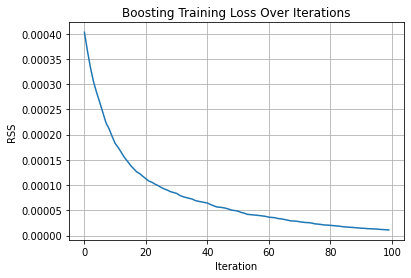

AMI: 0.2831
CABG: 0.0930
COPD: 0.1564
HF: 0.1658
HIP-KNEE: 0.1966
PN: 0.1052
Final training error: 1.1102994219720483e-05


In [25]:
# Split data into predictors and response
X = hospital_df[['AMI', 'CABG',	'COPD',	'HF', 'HIP-KNEE', 'PN']]
X = X.to_numpy()
y = hospital_df['Readmission Rate'].values

# Fit the boosting model
model = Boosting()
model.fit(X, y)

# Plot loss over time
plt.plot(model.losses)
plt.xlabel('Iteration')
plt.ylabel('RSS')
plt.title('Boosting Training Loss Over Iterations')
plt.grid(True)
plt.show()

# Print final training error
model.feature_importance(num_features=6, feature_names=['AMI', 'CABG', 'COPD', 'HF', 'HIP-KNEE', 'PN']) 
print("Final training error:", model.losses[-1])

To help interperet the model, we can look at partial dependency plots using scikit-learn.

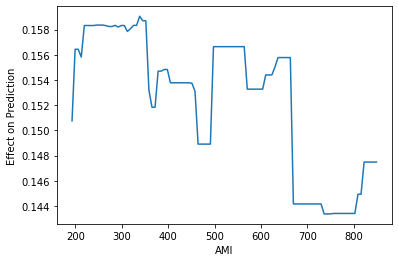

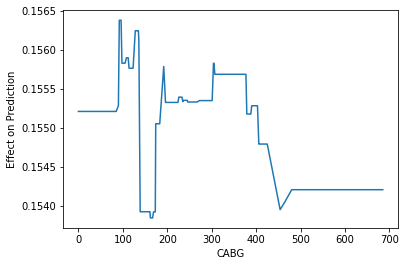

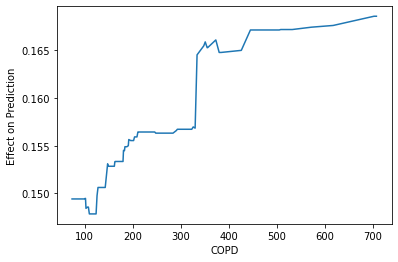

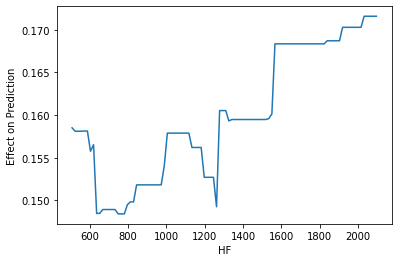

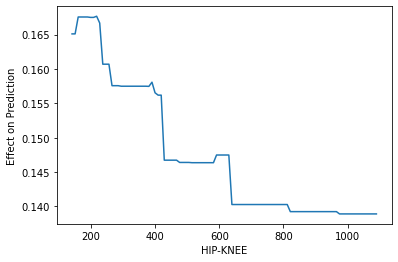

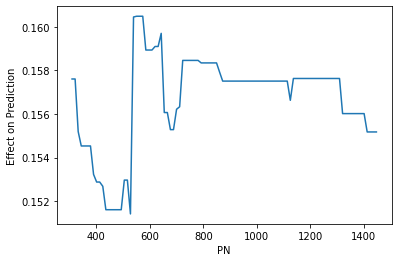

In [24]:
from sklearn.inspection import partial_dependence

def plot_pdp(model, X, feature_idx, feature_name):
    pdp = partial_dependence(model, X, [feature_idx], kind="average")
    plt.plot(pdp["grid_values"][0], pdp["average"][0])
    plt.xlabel(feature_name)
    plt.ylabel("Effect on Prediction")
    plt.show()

for i, feature in enumerate(['AMI', 'CABG', 'COPD', 'HF', 'HIP-KNEE', 'PN']):
    plot_pdp(model, X, i, feature);

Finally, using k-fold cross validation to validate the model. This uses the sklearn library KFold validator to estimate test error. This is a relatively small dataset (n=115), so LOOCV may be a feasible option, but the boosting tree is a slow learner so it is best to fit the model fewer times (in this case 5).

In [10]:
# Use sklearn library to perform k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Using 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = Boosting()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    mse_scores.append(mse)

print(f"Test error: {np.mean(mse_scores):.4f}")

Test error: 0.0003


We get a training error of .00001 and a test error of 0.0003. The test error is about 30x bigger than the training error, so this may indicate overfitting, but it is still a relatively small error.